In [76]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import combinations
import sys
from IPython.display import clear_output
import time

# Projet RP : Problème d’´equilibage de charge : glouton et recherche locale

In [77]:
def affichage(dico) :
    """ Args :
        dico (dict) : dictionnaire de machines (d'un ordonnancement)
        return (void) : affichage propre d'un ordonnancement
    """
    
    maxi = 0
    print("ordonnancement :")
    for key in dico.keys() :
        print("\tmachine", key, ":")
        
        if len(dico[key][0]) == 0 :
            print("\t\tpas de tâches assignées")
            
        for i in range(len(dico[key][0])) :
            print("\t\ttache", dico[key][0][i], " de duree", dico[key][1][i])
        
        makespan = sum(dico[key][1])
        print("\t\tduree totale : ", makespan)
        
        if makespan > maxi :
            maxi = makespan
    
    print("\tmakespan =", maxi,"\n")

In [78]:
def genererTaches(nb_taches,dureeMaxTache):
    """ Args :
        nb_taches (int) : nombre de taches a repartir
        dureeMaxTache (int) : duree maximale d une tache
        Return (dict) : dictionnaire qui a chaque cle (id d une tache) associe sa duree
    """
    
    dict_taches = dict()
    
    for i in range(nb_taches):
        dict_taches[i] = np.random.randint(1,dureeMaxTache)
        
    return dict_taches

In [79]:
def ordonneTaches(dict_taches):
    """ Args :
        dict_taches (dict) : dictionnaire qui a chaque cle (id d une tache) associe sa duree
        return ([int]) : liste des taches par ordre decroissant de leur duree
    """
    
    # on ordonne le dictionnaire par ordre decroissant de ses valeurs
    dict_sorted = dict(sorted(dict_taches.items(), key=lambda item: item[1], reverse=True))
    
    return list(dict_sorted.keys())


def getMachineDispo(dict_taches, dict_machines):
    """ Args :
        dict_taches (dict) : dictionnaire qui a chaque cle (id d une tache) associe sa duree
        dict_machines (dict) : dictionnaire qui a chaque cle (id d une machine) associe deux listes (une pour les taches associees et l autre pour la duree de la tache associee)
        Return (int) : le numero de la machine qui tourne le moins longtemps sur toutes les machines du dictionnaire
    """
    
    # initialisation du minimum par le maximum possible et init du numero de la machine dispo
    mini = sys.float_info.max
    machine_mini = 0
    
    # on parcourt le dictionnaire des machines
    for cle, val in dict_machines.items():
        # on calcule la somme des durees de chaque machine et on garde dans machine_mini celle 
        # qui a la duree la moins grande
        somme_taches = sum(val[1])
        if(mini>somme_taches):
            mini = somme_taches
            machine_mini = cle
            
    return machine_mini


## I. Algorithme de liste

In [80]:
def algoListe(dict_taches, nb_machines, isLPT=False):
    """ Args : 
        dict_taches (dict) : dictionnaire qui a chaque cle (id d une tache) associe sa duree
        nb_machines (int) : nombre de machines total
        isLPT (bool) : True si on ordonne la liste des taches au debut de l'algo, False sinon
        Return (dict) : dictionnaire qui a chaque cle (id d une machine) associe deux listes (une pour les taches associees et l autre pour la duree de la tache associee)
    """
    # init du dictionnaire de retour
    machines = dict()
    for i in range(nb_machines):
        machines[i] = [[],[]]
    
    # gerer le cas ou on ordonne la liste des taches
    if(isLPT):
        liste_priorite = ordonneTaches(dict_taches)
    else:
        liste_priorite = list(dict_taches.keys())
    
    # on parcourt la liste des taches et on assigne chaque tache a la premiere machine disponible 
    for tache_id in liste_priorite:
        m = getMachineDispo(dict_taches, machines)
        machines[m][0].append(tache_id)
        machines[m][1].append(dict_taches[tache_id])
        
    return machines


dict_taches = genererTaches(5, 10)
print(dict_taches)

# liste = ordonneTaches(dict_taches)
# print(liste)

machines = algoListe(dict_taches, 3)
affichage(machines)

{0: 8, 1: 2, 2: 7, 3: 7, 4: 4}
ordonnancement :
	machine 0 :
		tache 0  de duree 8
		duree totale :  8
	machine 1 :
		tache 1  de duree 2
		tache 3  de duree 7
		duree totale :  9
	machine 2 :
		tache 2  de duree 7
		tache 4  de duree 4
		duree totale :  11
	makespan = 11 



## II. Algorithme LPT

In [81]:
def algoListeLPT(dict_taches, nb_machines):
    """ Args :
        dict_taches (dict) : dictionnaire qui a chaque cle (id d une tache) associe sa duree
        nb_machines (int) : nombre de machines total
        Return (dict) : dictionnaire qui a chaque cle (id d une machine) associe deux listes (une pour les taches associees et l autre pour la duree de la tache associee)
    """
    
    return algoListe(dict_taches, nb_machines, True)

print(ordonneTaches(dict_taches))
machines_LPT = algoListeLPT(dict_taches, 3)
affichage(machines_LPT)

[0, 2, 3, 4, 1]
ordonnancement :
	machine 0 :
		tache 0  de duree 8
		duree totale :  8
	machine 1 :
		tache 2  de duree 7
		tache 4  de duree 4
		duree totale :  11
	machine 2 :
		tache 3  de duree 7
		tache 1  de duree 2
		duree totale :  9
	makespan = 11 



## III. Heuristique de recherche locale pour toutes les combinaisons de types de voisinage et de critère.


In [82]:
def ordon_alea(dict_taches, nb_machines):
    """ Args :
        dict_taches (dict) : dictionnaire qui a chaque cle (id d une tache) associe sa duree
        nb_machines (int) : nombre de machines total
        Return (dict) : dictionnaire qui a chaque cle (id d une machine) associe deux listes (une pour les taches associees et l autre pour la duree de la tache associee)
    """
    
    # init du dictionnaire de retour
    machines = dict()
    for i in range(nb_machines):
        machines[i] = [[],[]]
     
    # on parcourt les taches et on les insere dans une machine choisit aleatoirement
    for id_tache,duree in dict_taches.items():
        nb_alea = np.random.randint(nb_machines)
        machines[nb_alea][0].append(id_tache)
        machines[nb_alea][1].append(duree)
    
    return machines


dict_taches = genererTaches(4, 5)

affichage(ordon_alea(dict_taches, 2))

ordonnancement :
	machine 0 :
		tache 0  de duree 3
		tache 3  de duree 2
		duree totale :  5
	machine 1 :
		tache 1  de duree 3
		tache 2  de duree 3
		duree totale :  6
	makespan = 6 



In [83]:
def insertion(dict_taches, nb_machines, ordon_init):
    """ Args :
        dict_taches (dict) : dictionnaire qui a chaque cle (id d une tache) associe sa duree
        nb_machines (int) : nombre de machines total
        ordon_init (dict) : dictionnaire initial des machines
        Return ([dict]) : liste des differents voisinages de ordon_init (sous forme de dict de machines) selon la méthode d'insertion
    """
    
    # init de la liste de voisinage
    machines = ordon_init
    voisinage = []
    
    # pour chaque machine, on parcourt chacune de ses taches pour les insérer dans chacune des autres machines
    for i in range(nb_machines):
        for j in range(len(machines[i][0])):
            for k in range(nb_machines) :
                
                # on ne veut pas inserer la tache dans la meme machine (elle y est deja)
                if k == i :
                    continue
                    
                # on copie le dictionnaire des machines dans une variable temporaire pour pouvoir le modifier (et construire un voisin)
                tmp = deepcopy(machines)
                
                # deplacement de la tache j de la machine i vers la machine k
                id_tache = tmp[i][0][j] 
                duree = tmp[i][1][j]
                
                del(tmp[i][0][j])
                del(tmp[i][1][j])
                
                tmp[k][0].append(id_tache)
                tmp[k][1].append(duree)
                
                # ajout du voisin dans la liste de voisinage
                voisinage.append(tmp)
                
    return voisinage

ordon_init = ordon_alea(dict_taches, 3)
print("ordonnancement de départ", ordon_init)
print("voisinage = ")

for ordonnancement in insertion(dict_taches, 3, ordon_init):
    affichage(ordonnancement)
    

ordonnancement de départ {0: [[2], [3]], 1: [[1], [3]], 2: [[0, 3], [3, 2]]}
voisinage = 
ordonnancement :
	machine 0 :
		pas de tâches assignées
		duree totale :  0
	machine 1 :
		tache 1  de duree 3
		tache 2  de duree 3
		duree totale :  6
	machine 2 :
		tache 0  de duree 3
		tache 3  de duree 2
		duree totale :  5
	makespan = 6 

ordonnancement :
	machine 0 :
		pas de tâches assignées
		duree totale :  0
	machine 1 :
		tache 1  de duree 3
		duree totale :  3
	machine 2 :
		tache 0  de duree 3
		tache 3  de duree 2
		tache 2  de duree 3
		duree totale :  8
	makespan = 8 

ordonnancement :
	machine 0 :
		tache 2  de duree 3
		tache 1  de duree 3
		duree totale :  6
	machine 1 :
		pas de tâches assignées
		duree totale :  0
	machine 2 :
		tache 0  de duree 3
		tache 3  de duree 2
		duree totale :  5
	makespan = 6 

ordonnancement :
	machine 0 :
		tache 2  de duree 3
		duree totale :  3
	machine 1 :
		pas de tâches assignées
		duree totale :  0
	machine 2 :
		tache 0  de duree 3
		tach

In [84]:
def echange(dict_taches, nb_machines, ordon_init):
    """ Args :
        dict_taches (dict) : dictionnaire qui a chaque cle (id d une tache) associe sa duree
        nb_machines (int) : nombre de machines total
        ordon_init (dict) : dictionnaire initial des machines
        Return ([dict]) : liste des differents voisinages de ordon_init (sous forme de dict de machines) selon la methode d echanges
    """
    
    # init de la liste de voisinage
    machines = ordon_init
    voisinage = []
    
    #Pour chaque machine, on parcourt chacune de ses taches
    for i in range(nb_machines):
        for j in range(len(machines[i][0])):
            # Maintenant qu on a une tache associee a une machine, on parcourt chaque tache d une autre machine qui suit (pour eviter les doublons)
            for k in range(i+1, nb_machines) :
                for l in range(len(machines[k][0])) :
                    
                    # on copie le dictionnaire des machines dans une variable temporaire pour pouvoir le modifier (et construire un voisin)
                    tmp = deepcopy(machines)
                    
                    # echange des deux taches j et l entre les machines i et k
                    id_tache1 = tmp[i][0][j] 
                    duree1 = tmp[i][1][j]
                
                    tmp[i][0][j] = tmp[k][0][l]
                    tmp[i][1][j] = tmp[k][1][l]
                
                    tmp[k][0][l] = id_tache1
                    tmp[k][1][l] = duree1
                
                    # ajout du voisin dans la liste de voisinage
                    voisinage.append(tmp)
                
    return voisinage
    
print("ordonnancement de départ", ordon_init)
print("voisinage = ")
voisins = echange(dict_taches, 2, ordon_init)
for ordonnancement in voisins:
    affichage(ordonnancement)

ordonnancement de départ {0: [[2], [3]], 1: [[1], [3]], 2: [[0, 3], [3, 2]]}
voisinage = 
ordonnancement :
	machine 0 :
		tache 1  de duree 3
		duree totale :  3
	machine 1 :
		tache 2  de duree 3
		duree totale :  3
	machine 2 :
		tache 0  de duree 3
		tache 3  de duree 2
		duree totale :  5
	makespan = 5 



In [85]:
def permutation(dict_taches, nb_machines, ordon_init) :
    """ Args :
        dict_taches (dict) : dictionnaire qui a chaque cle (id d une tache) associe sa duree
        nb_machines (int) : nombre de machines total
        ordon_init (dict) : dictionnaire initial des machines
        Return ([dict]) : liste des differents voisinages de ordon_init (sous forme de dict de machines) selon la methode de permutation
    """
    
    # init de la liste de voisinage
    machines = ordon_init
    voisinage = []
    
    # on parcourt les machines pour trouver deux machines i et j
    for i in range(nb_machines):
        for j in range(i+1, nb_machines):
            
            # on recupere les listes des taches associees aux deux machines i et j, 
            # puis on les fusionne pour obtenir tous les sous ensembles possibles
            set1 = set(machines[i][0])
            set2 = set(machines[j][0])
            set_f = set1 | set2
            list_subsets = sum(map(lambda r: list(combinations(set_f,r)), range(0, len(set_f)+1)), [])
            
            # Pour chaque sous ensemble possible, on l'affecte a la premiere machine i  
            # et on affecte son complementaire dans la deuxieme machine j
            for subset in list_subsets :
                
                tmp = deepcopy(machines)
                tmp[i][0] = list(subset)
                tmp[j][0] = list(set_f - set(subset))
                
                tmp[i][1].clear()
                tmp[j][1].clear()
                
                # on recreer la liste des durees associee a la nouvelle liste des taches de la machine
                for id_tache in tmp[i][0]:
                    tmp[i][1].append(dict_taches[id_tache])
                for id_tache in tmp[j][0]:
                    tmp[j][1].append(dict_taches[id_tache])
                 
                # ajout du voisin dans la liste de voisinage
                voisinage.append(tmp)
                
    return voisinage

ordon_init = ordon_alea(dict_taches, 3)
print("ordonnancement de départ", ordon_init)
print("voisinage = ")
for ordonnancement in permutation(dict_taches, 3, ordon_init):
    affichage(ordonnancement)

ordonnancement de départ {0: [[0, 1, 2], [3, 3, 3]], 1: [[3], [2]], 2: [[], []]}
voisinage = 
ordonnancement :
	machine 0 :
		pas de tâches assignées
		duree totale :  0
	machine 1 :
		tache 0  de duree 3
		tache 1  de duree 3
		tache 2  de duree 3
		tache 3  de duree 2
		duree totale :  11
	machine 2 :
		pas de tâches assignées
		duree totale :  0
	makespan = 11 

ordonnancement :
	machine 0 :
		tache 0  de duree 3
		duree totale :  3
	machine 1 :
		tache 1  de duree 3
		tache 2  de duree 3
		tache 3  de duree 2
		duree totale :  8
	machine 2 :
		pas de tâches assignées
		duree totale :  0
	makespan = 8 

ordonnancement :
	machine 0 :
		tache 1  de duree 3
		duree totale :  3
	machine 1 :
		tache 0  de duree 3
		tache 2  de duree 3
		tache 3  de duree 2
		duree totale :  8
	machine 2 :
		pas de tâches assignées
		duree totale :  0
	makespan = 8 

ordonnancement :
	machine 0 :
		tache 2  de duree 3
		duree totale :  3
	machine 1 :
		tache 0  de duree 3
		tache 1  de duree 3
		tache 3  

In [86]:
def makespan(dico) :
    """ Args :
        dico (dict) : dictionnaire de machines
        return (int) : le maskespan de cet ordonnancement
    """
    # init du maximum
    maxi = 0
    # calcul des durees totales de chaque machine et renvoie de la plus grande
    for key in dico.keys() :
        makespan = sum(dico[key][1])
        
        if makespan > maxi :
            maxi = makespan
    
    return maxi


def nb_critiques(dico):
    """ Args :
        dico (dict) : dictionnaire de machines
        return (int) : nb de machines critiques pour l ordonnancement
    """
    
    # init du compteur + recuperer le makespan pour savoir quelles machines sont critiques 
    mp = makespan(dico)
    nb_crit = 0
    
    # parcours de chaque machine : on incremente le compteur des qu une machine est critique
    for key in dico.keys() :
        if(sum(dico[key][1])==mp):
            nb_crit += 1
    
    return nb_crit


def machines_changees(ordon_actuel, voisin) :
    """ Args :
        ordon_actuel (dict) : dictionnaire d un ordonnancement
        voisin (dict) : dictionnaire d un ordonnancement voisin au premier
        return ([int]) : liste des machines modifiees entre les deux ordonnancement
    """
    # init liste retour
    indices = []
    # parcours de chaque machine des deux ordonnancements pour comparer si elles ont les memes taches assignees
    for key in ordon_actuel.keys() :
        if ordon_actuel[key][0] != voisin[key][0] :
            indices.append(key)
    
    # Le voisinage permutation créer des voisinages identiques à l'ordonnancement de base
    # Si c'est le cas aucune machine est changées
    if(len(indices)!=2):
        return [0,1]
    return indices

In [87]:
def cmax(ordon_actuel, voisin) :
    """ Args :
        ordon_actuel (dict) : dictionnaire d un ordonnancement
        voisin (dict) : dictionnaire d un ordonnancement voisin au premier
        return (bool) : True si le voisin est ameliorant selon cmax, False sinon
    """
    makespan1 = makespan(ordon_actuel)
    makespan2 = makespan(voisin)
    
    return makespan2<makespan1

In [88]:
def lexico(ordon_actuel, voisin):
    """ Args :
        ordon_actuel (dict) : dictionnaire d un ordonnancement
        voisin (dict) : dictionnaire d un ordonnancement voisin au premier
        return (bool) : True si le voisin est ameliorant selon lexico, False sinon
    """
    
    makespan1 = makespan(ordon_actuel)
    makespan2 = makespan(voisin)
    
    # premiere comparaison facon cmax
    if(makespan2<makespan1):
        return True
    
    # deuxieme comparaison selon deuxieme critere lexico
    elif(makespan2==makespan1):
        nb_crit1 = nb_critiques(ordon_actuel)
        nb_crit2 = nb_critiques(voisin)
        return nb_crit2<nb_crit1
    
    else :
        return False

In [89]:
def pair(ordon_actuel, voisin) :
    """ Args :
        ordon_actuel (dict) : dictionnaire d un ordonnancement
        voisin (dict) : dictionnaire d un ordonnancement voisin au premier
        return (bool) : True si le voisin est ameliorant selon pair, False sinon
    """
    
    # recup des indices des deux machines changees
    i,j = machines_changees(ordon_actuel, voisin)
    
    # calcul de leur duree dans les deux ordonnancements
    duree_i_actu = sum(ordon_actuel[i][1])
    duree_j_actu = sum(ordon_actuel[j][1])
    duree_i_vois = sum(voisin[i][1])
    duree_j_vois = sum(voisin[j][1])
    
    return max(duree_i_vois,duree_j_vois) < max(duree_i_actu,duree_j_actu)

In [90]:
affichage(ordon_init)
print("\nvoisinage = ")
voisinage_insert = insertion(dict_taches, 3, ordon_init)
affichage(voisinage_insert[0])
print(cmax(ordon_init,voisinage_insert[0]))

ordonnancement :
	machine 0 :
		tache 0  de duree 3
		tache 1  de duree 3
		tache 2  de duree 3
		duree totale :  9
	machine 1 :
		tache 3  de duree 2
		duree totale :  2
	machine 2 :
		pas de tâches assignées
		duree totale :  0
	makespan = 9 


voisinage = 
ordonnancement :
	machine 0 :
		tache 1  de duree 3
		tache 2  de duree 3
		duree totale :  6
	machine 1 :
		tache 3  de duree 2
		tache 0  de duree 3
		duree totale :  5
	machine 2 :
		pas de tâches assignées
		duree totale :  0
	makespan = 6 

True


In [91]:
ordon_init = ordon_alea(dict_taches, 3)
affichage(ordon_init)
voisinage_permut = permutation(dict_taches, 3, ordon_init) 

print("\nvoisinage = ")
for voisin in voisinage_permut :
    affichage(voisin)
    print(cmax(ordon_init,voisin))
    print("")

ordonnancement :
	machine 0 :
		tache 3  de duree 2
		duree totale :  2
	machine 1 :
		tache 2  de duree 3
		duree totale :  3
	machine 2 :
		tache 0  de duree 3
		tache 1  de duree 3
		duree totale :  6
	makespan = 6 


voisinage = 
ordonnancement :
	machine 0 :
		pas de tâches assignées
		duree totale :  0
	machine 1 :
		tache 2  de duree 3
		tache 3  de duree 2
		duree totale :  5
	machine 2 :
		tache 0  de duree 3
		tache 1  de duree 3
		duree totale :  6
	makespan = 6 

False

ordonnancement :
	machine 0 :
		tache 2  de duree 3
		duree totale :  3
	machine 1 :
		tache 3  de duree 2
		duree totale :  2
	machine 2 :
		tache 0  de duree 3
		tache 1  de duree 3
		duree totale :  6
	makespan = 6 

False

ordonnancement :
	machine 0 :
		tache 3  de duree 2
		duree totale :  2
	machine 1 :
		tache 2  de duree 3
		duree totale :  3
	machine 2 :
		tache 0  de duree 3
		tache 1  de duree 3
		duree totale :  6
	makespan = 6 

False

ordonnancement :
	machine 0 :
		tache 2  de duree 3
		tache

In [92]:
ordon_init = {0:[[0,3],[4,2]], 1:[[],[]], 2:[[1,2],[2,4]]}
affichage(ordon_init)
voisinage_permut = permutation(dict_taches, 3, ordon_init) 

print("\nvoisinage = ")
for voisin in voisinage_permut :
    affichage(voisin)
    print(lexico(ordon_init,voisin))
    print("")

ordonnancement :
	machine 0 :
		tache 0  de duree 4
		tache 3  de duree 2
		duree totale :  6
	machine 1 :
		pas de tâches assignées
		duree totale :  0
	machine 2 :
		tache 1  de duree 2
		tache 2  de duree 4
		duree totale :  6
	makespan = 6 


voisinage = 
ordonnancement :
	machine 0 :
		pas de tâches assignées
		duree totale :  0
	machine 1 :
		tache 0  de duree 3
		tache 3  de duree 2
		duree totale :  5
	machine 2 :
		tache 1  de duree 2
		tache 2  de duree 4
		duree totale :  6
	makespan = 6 

True

ordonnancement :
	machine 0 :
		tache 0  de duree 3
		duree totale :  3
	machine 1 :
		tache 3  de duree 2
		duree totale :  2
	machine 2 :
		tache 1  de duree 2
		tache 2  de duree 4
		duree totale :  6
	makespan = 6 

True

ordonnancement :
	machine 0 :
		tache 3  de duree 2
		duree totale :  2
	machine 1 :
		tache 0  de duree 3
		duree totale :  3
	machine 2 :
		tache 1  de duree 2
		tache 2  de duree 4
		duree totale :  6
	makespan = 6 

True

ordonnancement :
	machine 0 :
		tach

In [93]:
ordon_init = ordon_alea(dict_taches, 3)
affichage(ordon_init)
voisinage_permut = permutation(dict_taches, 3, ordon_init) 

print("\nvoisinage = ")
for voisin in voisinage_permut :
    affichage(voisin)
    print(pair(ordon_init,voisin))
    print("")

ordonnancement :
	machine 0 :
		tache 3  de duree 2
		duree totale :  2
	machine 1 :
		tache 0  de duree 3
		tache 1  de duree 3
		duree totale :  6
	machine 2 :
		tache 2  de duree 3
		duree totale :  3
	makespan = 6 


voisinage = 
ordonnancement :
	machine 0 :
		pas de tâches assignées
		duree totale :  0
	machine 1 :
		tache 0  de duree 3
		tache 1  de duree 3
		tache 3  de duree 2
		duree totale :  8
	machine 2 :
		tache 2  de duree 3
		duree totale :  3
	makespan = 8 

False

ordonnancement :
	machine 0 :
		tache 0  de duree 3
		duree totale :  3
	machine 1 :
		tache 1  de duree 3
		tache 3  de duree 2
		duree totale :  5
	machine 2 :
		tache 2  de duree 3
		duree totale :  3
	makespan = 5 

True

ordonnancement :
	machine 0 :
		tache 1  de duree 3
		duree totale :  3
	machine 1 :
		tache 0  de duree 3
		tache 3  de duree 2
		duree totale :  5
	machine 2 :
		tache 2  de duree 3
		duree totale :  3
	makespan = 5 

True

ordonnancement :
	machine 0 :
		tache 3  de duree 2
		duree t

In [94]:
def get_ameliorant(ordon_init, voisinage, calcul_criteres) :
    """ Args :
        ordon_init (dict) : dictionnaire d un ordonnancement
        voisinage ([dict]) : liste de tous les ordonnancements voisins d ordon_init
        calcul_criteres (function) : fonction criteres utilisee pour determiner les voisins ameliorant
        return ([dict]) : liste des voisins ameliorant d ordon_init
    """
    
    # init liste retour
    res = []
    
    # on determine si chaque voisin est ameliorant ou non
    # si oui, on l ajoute a la liste
    for voisin in voisinage :
        if calcul_criteres(ordon_init, voisin) :
            res.append(voisin)
            
    return res

In [95]:
print(len(get_ameliorant(ordon_init,voisinage_permut,pair)))

4


In [96]:
def recherche_heuristique(ordon_actu, dict_taches, nb_machines, calcul_voisins, calcul_criteres) :
    """ Args :
        ordon_actu (dict) : dictionnaire d un ordonnancement
        dict_taches (dict) : dictionnaire des taches {id : duree}
        nb_machines (int) : nombre de machines dont on dispose
        calcul_voisins (function) : fonction de calcul du voisinage de la solution courante
        calcul_criteres (function) : fonction criteres utilisee pour determiner les voisins ameliorant
        return (dict) : meilleure ordonnancement obtenu apres recherche locale depuis la solution ordon_actu
    """
    
    # affichage de l ordonnancement de depart
    #print("Ordonnancement initial :")
    #affichage(ordon_actu)
    
    # calcul du voisinage total et recuperation des ameliorants
    voisinage = calcul_voisins(dict_taches, nb_machines, ordon_actu)
    ameliorants = get_ameliorant(ordon_actu, voisinage, calcul_criteres)
    #print("nombre d'améliorants possibles :", len(ameliorants))
    
    # tant qu on peut trouver des solutions ameliorantes, 
    # on recommence a partir d un voisin ameliorant choisi au hasard
    while len(ameliorants) != 0 :
        alea = np.random.randint(len(ameliorants))
        ordon_actu = ameliorants[alea]
        #print("\nAméliorant choisi")
        #affichage(ordon_actu)
        voisinage = calcul_voisins(dict_taches, nb_machines, ordon_actu)
        ameliorants = get_ameliorant(ordon_actu, voisinage, calcul_criteres)
        #print("nombre d'améliorants possibles :", len(ameliorants))
     
    #print("dernier améliorant trouvé")
    #affichage(ordon_actu)
    #print("\nPlus d'améliorants")
 
    return ordon_actu
    

In [97]:
dict_taches = genererTaches(4,5)
ordon_init = ordon_alea(dict_taches,3)
recherche_heuristique(ordon_init, dict_taches, 3, permutation, cmax)
recherche_heuristique(ordon_init, dict_taches, 3, permutation, cmax)
recherche_heuristique(ordon_init, dict_taches, 3, permutation, cmax)
recherche_heuristique(ordon_init, dict_taches, 3, permutation, cmax)
recherche_heuristique(ordon_init, dict_taches, 3, permutation, cmax)

## on obtient des solutions différentes pour 5 exécutions identiquesa

{0: [[0, 2], [1, 2]], 1: [[3], [4]], 2: [[1], [4]]}

## IV. Comparaisons des méthodes de recherche heuristique

### Graphe en fonction du nombre de machines pour n taches

In [98]:
def graph_machines_VoisinbyCritere(nb_taches, duree_max, nb_machines, nb_moyen, list_voisinage):
    """ Args :
        n (int) : nombre de tâches
        duree_max (int) : durée maximale d'une tâche
        nb_machines (list{int}) : liste de différents nombre de machines dont on dispose
        nb_moyen (int) : nombre de répétitions pour chaque combinaisons
        list_voisinage (list{function}) : list de fonction de voisinage
        return (void) : Affiche des graphiques du temps d'exécution / qualité de solution en fonction du nombre de machines
    """
    temps = np.zeros((9, nb_machines.shape[0]))
    qualite = np.zeros((9, nb_machines.shape[0]))

    fig = plt.figure()
    fig.set_size_inches(18.5, 20)
    fig.set_dpi(100)
    
    ax1 = fig.add_subplot(3,2,1) # tps d'exécution / variation nb machines pour insertion 
    ax2 = fig.add_subplot(3,2,2) # qualité / variation nb machines pour insertion 
    ax3 = fig.add_subplot(3,2,3) # tps d'exécution / variation nb machines pour échange
    ax4 = fig.add_subplot(3,2,4) # qualité / variation nb machines pour échange 
    ax5 = fig.add_subplot(3,2,5) # tps d'exécution / variation nb machines pour permutation
    ax6 = fig.add_subplot(3,2,6) # qualité / variation nb machines pour permutation 

    dico_combinaison = {0:"insertion cmax", 1:"insertion lexico", 2:"insertion pair", 
                        3:"echange cmax", 4:"echange lexico", 5:"echange pair",
                        6:"permutation cmax", 7:"permutation lexico", 8:"permutation pair"}

    for j in range(nb_machines.shape[0]) :
        dict_taches = genererTaches(nb_taches, duree_max)
        ordon_init = ordon_alea(dict_taches, nb_machines[j])

        for i in range(nb_moyen) :
            if i%5 == 0 :
                ordon_init = ordon_alea(dict_taches, nb_machines[j])

            cpt = 0
            for voisinage in list_voisinage :
                for critere in [cmax, lexico, pair] :
                    clear_output(wait=True)
                    print("Loading ... \n Machine %d / %d \n\t Répétitions : %d / %d \n\t\t Critere / voisinage %d / %d \n " %(j+2, nb_machines[-1], i, nb_moyen, cpt+1, 9))
                    
                    t1 = time.time()
                    optimum_local = recherche_heuristique(ordon_init, dict_taches, nb_machines[j], voisinage, critere)
                    t2 = time.time()
                    t = t2-t1
                    temps[cpt][j] += t
                    qualite[cpt][j] += makespan(optimum_local)
                    cpt += 1
    

    for i in range(9):
        label = dico_combinaison[i]
        if(i<3):         
            ax1.plot(nb_machines, temps[i]/nb_moyen, label=label)
            ax2.plot(nb_machines, qualite[i]/nb_moyen, label=label)
        elif(i<6):
            ax3.plot(nb_machines, temps[i]/nb_moyen, label=label)
            ax4.plot(nb_machines, qualite[i]/nb_moyen, label=label)
        else:
            ax5.plot(nb_machines, temps[i]/nb_moyen, label=label)
            ax6.plot(nb_machines, qualite[i]/nb_moyen, label=label)

    ax1.set_xlabel("Nombre de machines disponibles")
    ax1.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax1.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de machines pour le voisinage insertion (15 tâches)")

    ax2.set_xlabel("Nombre de machines disponibles")
    ax2.set_ylabel("Makespan des optimums locaux trouvés")
    ax2.set_title("Evolution de la qualité de solution\n en fonction du nombre de machines pour le voisinage insertion (15 tâches)")

    ax3.set_xlabel("Nombre de machines disponibles")
    ax3.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax3.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de machines pour le voisinages échange (15 tâches)")

    ax4.set_xlabel("Nombre de machines disponibles")
    ax4.set_ylabel("Makespan des optimums locaux trouvés")
    ax4.set_title("Evolution de la qualité de solution\n en fonction du nombre de machines pour le voisinages échange (15 tâches)")

    ax5.set_xlabel("Nombre de machines disponibles")
    ax5.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax5.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de machines pour le voisinages permutation (15 tâches)")

    ax6.set_xlabel("Nombre de machines disponibles")
    ax6.set_ylabel("Makespan des optimums locaux trouvés")
    ax6.set_title("Evolution de la qualité de solution\n en fonction du nombre de machines pour le voisinages permutation (15 tâches)")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    ax6.legend()

Loading ... 
 Machine 10 / 10 
	 Répétitions : 59 / 60 
		 Critere / voisinage 9 / 9 
 


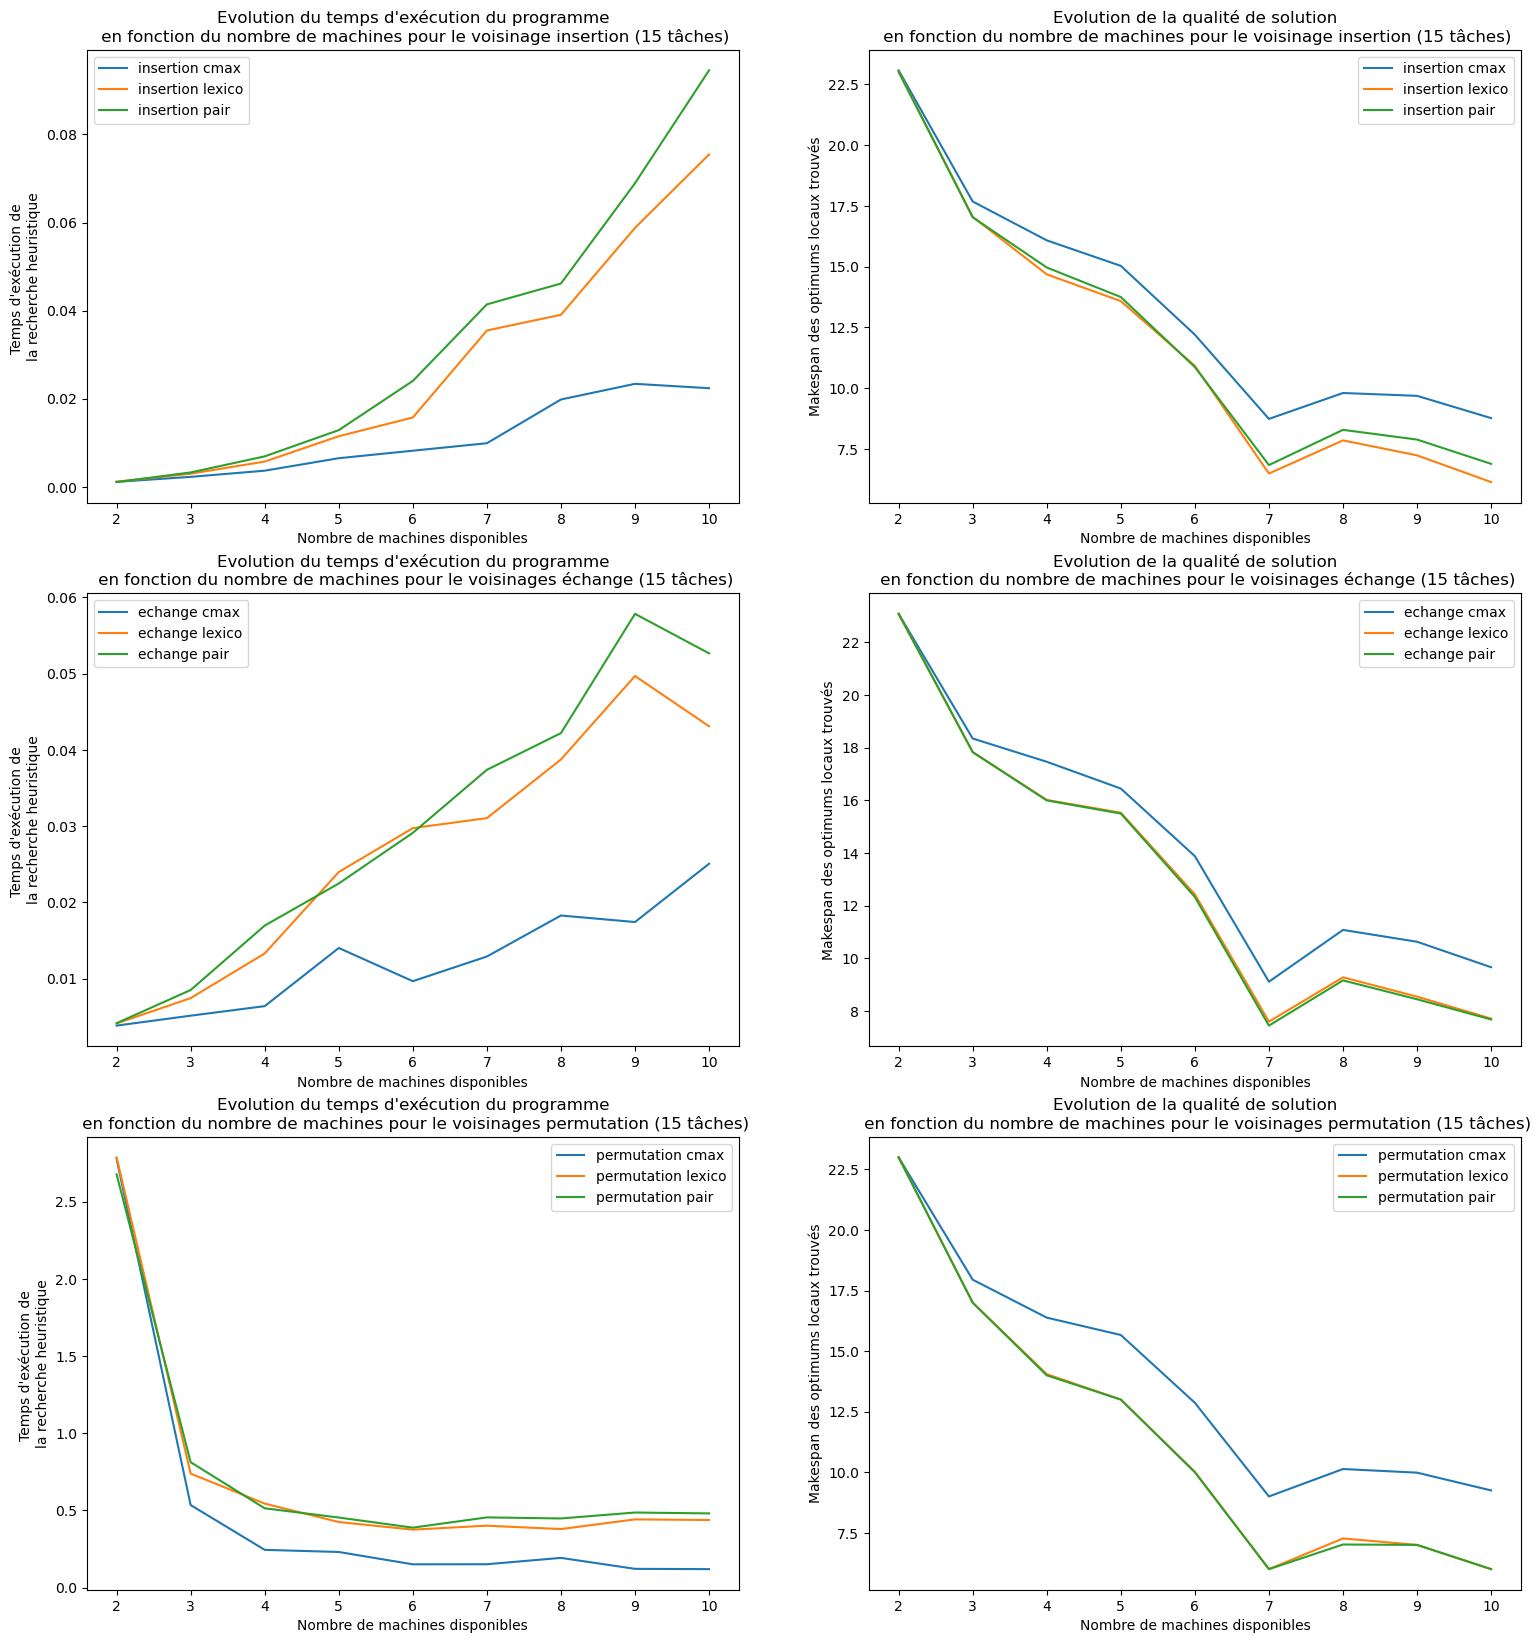

In [99]:
nb_taches = 15
duree_max = 7
nb_machines = np.arange(2,11)
nb_moyen = 60
list_voisinage = [insertion, echange, permutation]
graph_machines_VoisinbyCritere(nb_taches, duree_max, nb_machines, nb_moyen, list_voisinage)

In [100]:
def graph_machines_CriterebyVoisin(nb_taches, duree_max, nb_machines, nb_moyen, list_voisinage):
    """ Args :
        n (int) : nombre de tâches
        duree_max (int) : durée maximale d'une tâche
        nb_machines (list{int}) : liste de différents nombre de machines dont on dispose
        nb_moyen (int) : nombre de répétitions pour chaque combinaisons
        list_voisinage (list{function}) : list de fonction de voisinage
        return (void) : Affiche des graphiques du temps d'exécution / qualité de solution en fonction du nombre de machines
    """
    temps = np.zeros((9, nb_machines.shape[0]))
    qualite = np.zeros((9, nb_machines.shape[0]))

    fig = plt.figure()
    fig.set_size_inches(18.5, 20)
    fig.set_dpi(100)
    
    ax1 = fig.add_subplot(3,2,1) # tps d'exécution / variation nb machines pour cmax
    ax2 = fig.add_subplot(3,2,2) # qualité / variation nb machines pour cmax 
    ax3 = fig.add_subplot(3,2,3) # tps d'exécution / variation nb machines pour lexico
    ax4 = fig.add_subplot(3,2,4) # qualité / variation nb machines pour lexico
    ax5 = fig.add_subplot(3,2,5) # tps d'exécution / variation nb machines pour pair
    ax6 = fig.add_subplot(3,2,6) # qualité / variation nb machines pour pair

    dico_combinaison = {0:"insertion cmax", 3:" insertion lexico", 6:"insertion pair", 
                        1:"echange cmax", 4:"echange lexico", 7:"echange pair",
                        2:"permutation cmax", 5:"permutation lexico", 8:"permutation pair"}

    for j in range(nb_machines.shape[0]) :
        dict_taches = genererTaches(nb_taches, duree_max)
        ordon_init = ordon_alea(dict_taches, nb_machines[j])

        for i in range(nb_moyen) :
            if i%5 == 0 :
                ordon_init = ordon_alea(dict_taches, nb_machines[j])
            cpt = 0
            
            for critere in [cmax, lexico, pair] :
                for voisinage in list_voisinage :
                    clear_output(wait=True)
                    print("Loading ... \n Machine %d / %d \n\t Répétitions : %d / %d \n\t\t Critere / voisinage %d / %d \n " %(j+2, nb_machines[-1], i, nb_moyen, cpt+1, 9))
                    t1 = time.time()
                    optimum_local = recherche_heuristique(ordon_init, dict_taches, nb_machines[j], voisinage, critere)
                    t2 = time.time()
                    t = t2-t1
                    temps[cpt][j] += t
                    qualite[cpt][j] += makespan(optimum_local)
                    cpt += 1

    for i in range(9):
        label = dico_combinaison[i]
        if(i<3):         
            ax1.plot(nb_machines, temps[i]/nb_moyen, label=label)
            ax2.plot(nb_machines, qualite[i]/nb_moyen, label=label)
        elif(i<6):
            ax3.plot(nb_machines, temps[i]/nb_moyen, label=label)
            ax4.plot(nb_machines, qualite[i]/nb_moyen, label=label)
        else:
            ax5.plot(nb_machines, temps[i]/nb_moyen, label=label)
            ax6.plot(nb_machines, qualite[i]/nb_moyen, label=label)

    ax1.set_xlabel("Nombre de machines disponibles")
    ax1.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax1.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de machines pour le critère cmax (15 tâches)")

    ax2.set_xlabel("Nombre de machines disponibles")
    ax2.set_ylabel("Makespan des optimums locaux trouvés")
    ax2.set_title("Evolution de la qualité de solution\n en fonction du nombre de machines pour le critère cmax (15 tâches)")

    ax3.set_xlabel("Nombre de machines disponibles")
    ax3.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax3.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de machines pour le critère lexico (15 tâches)")

    ax4.set_xlabel("Nombre de machines disponibles")
    ax4.set_ylabel("Makespan des optimums locaux trouvés")
    ax4.set_title("Evolution de la qualité de solution\n en fonction du nombre de machines pour le critère lexico (15 tâches)")

    ax5.set_xlabel("Nombre de machines disponibles")
    ax5.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax5.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de machines pour le critère pair (15 tâches)")

    ax6.set_xlabel("Nombre de machines disponibles")
    ax6.set_ylabel("Makespan des optimums locaux trouvés")
    ax6.set_title("Evolution de la qualité de solution\n en fonction du nombre de machines pour le critère pair (15 tâches)")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    ax6.legend()

Loading ... 
 Machine 10 / 10 
	 Répétitions : 59 / 60 
		 Critere / voisinage 9 / 9 
 


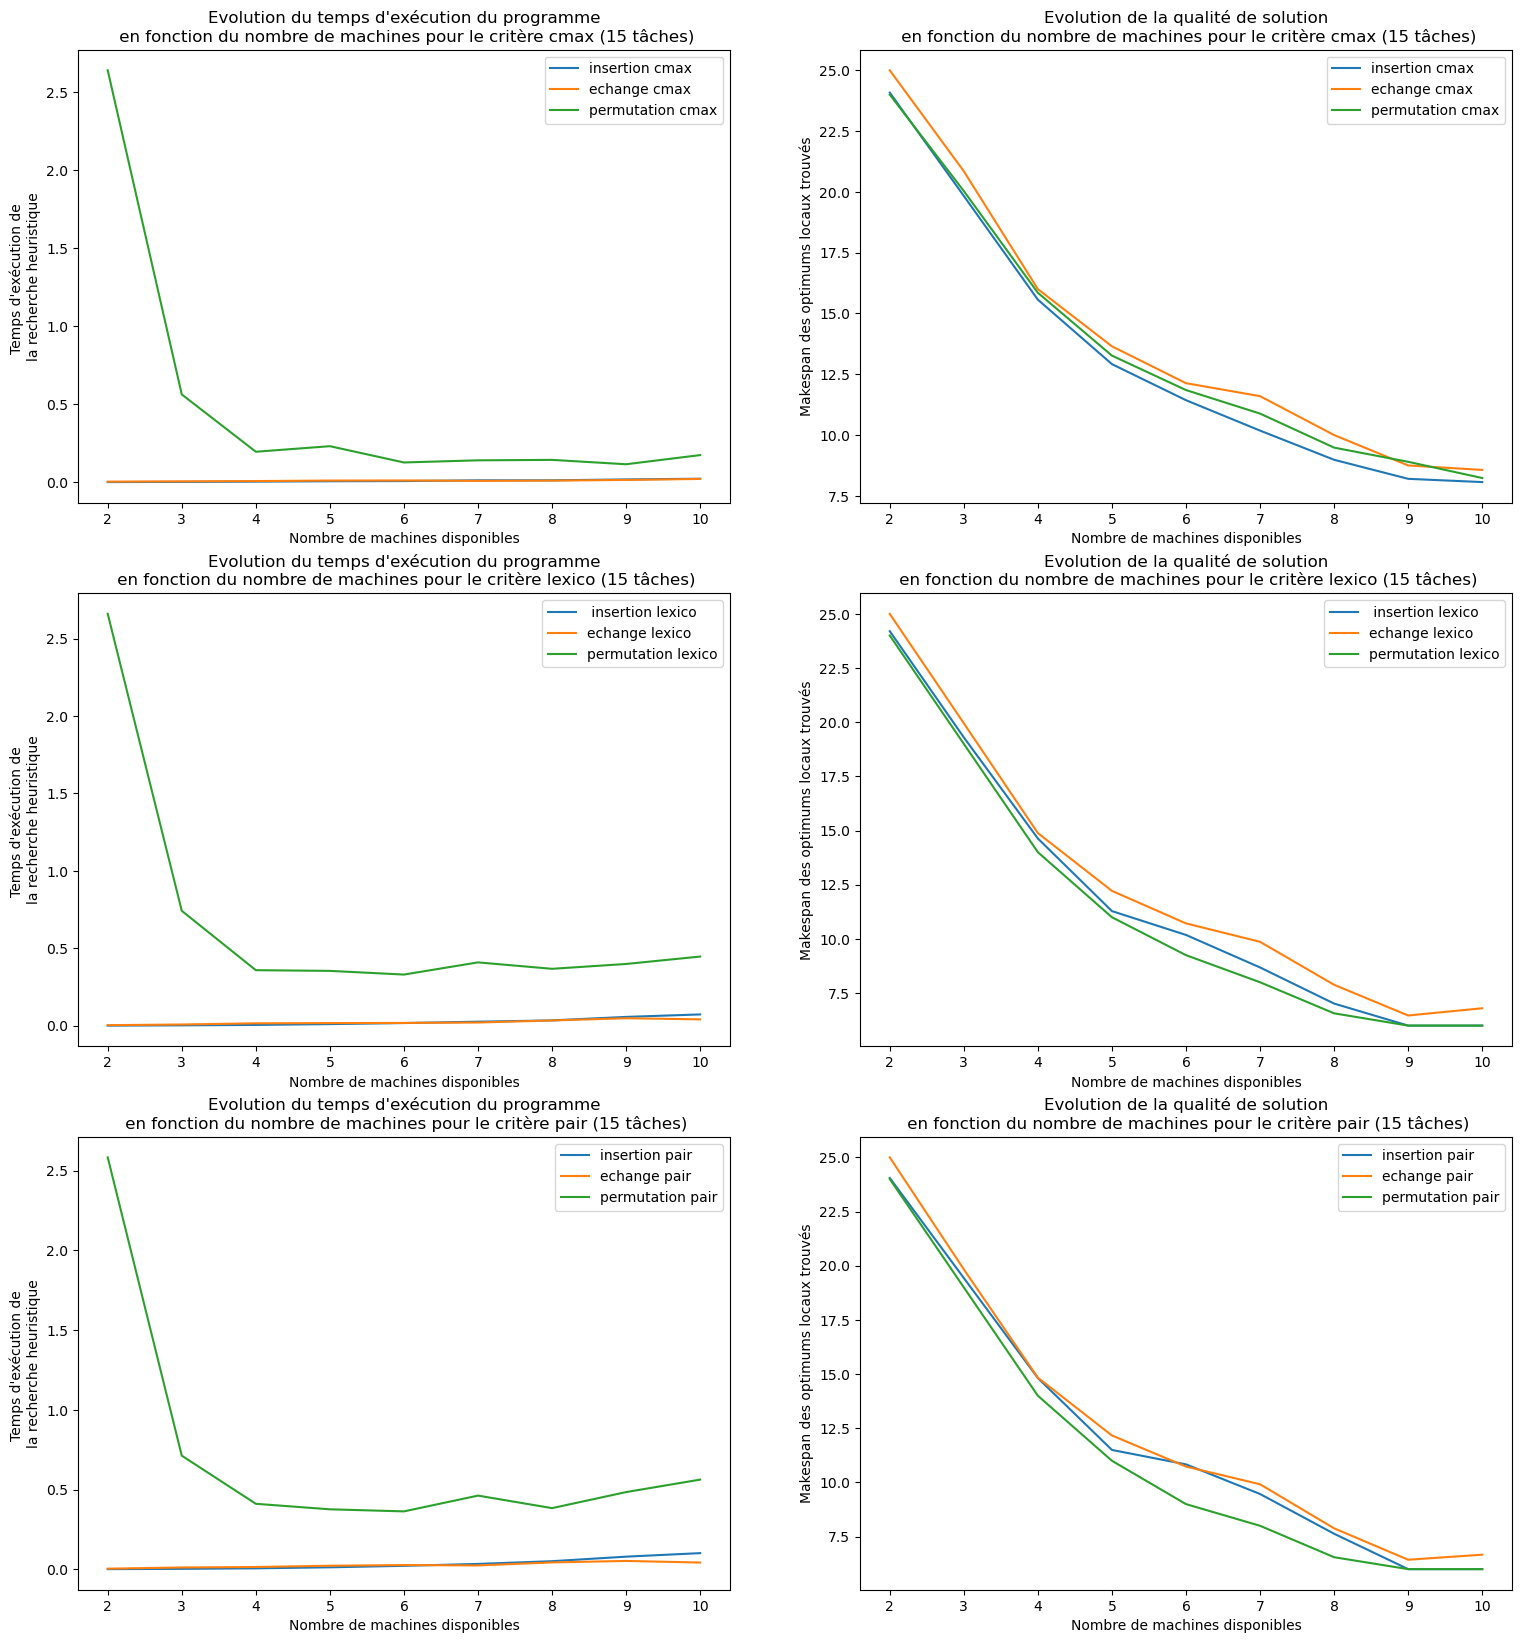

In [101]:
nb_taches = 15
duree_max = 7
nb_machines = np.arange(2,11)
nb_moyen = 60
list_voisinage = [insertion, echange, permutation]
graph_machines_CriterebyVoisin(nb_taches, duree_max, nb_machines, nb_moyen, list_voisinage)

In [102]:
def graph_nbTache_VoisinbyCritere(nb_taches, duree_max, nb_machines, nb_moyen, list_voisinage):
    """ Args :
        n (list{int}) : liste de différents nombres de tâches
        duree_max (int) : durée maximale d'une tâche
        nb_machines (int) : nombre de machines dont on dispose
        nb_moyen (int) : nombre de répétitions pour chaque combinaisons
        list_voisinage (list{function}) : list de fonction de voisinage
        return (void) : Affiche des graphiques du temps d'exécution / qualité de solution en fonction du nombre de tâches pour chaque voisinage
    """
    temps = np.zeros((9, nb_taches.shape[0]))
    qualite = np.zeros((9, nb_taches.shape[0]))

    fig = plt.figure()
    fig.set_size_inches(18.5, 20)
    fig.set_dpi(100)
    
    ax1 = fig.add_subplot(3,2,1) # tps d'exécution / variation nb machines pour insertion
    ax2 = fig.add_subplot(3,2,2) # qualité / variation nb machines pour insertion échange
    ax3 = fig.add_subplot(3,2,3) # tps d'exécution / variation nb machines pour échange
    ax4 = fig.add_subplot(3,2,4) # qualité / variation nb machines pour échange
    ax5 = fig.add_subplot(3,2,5) # tps d'exécution / variation nb machines pour permutation
    ax6 = fig.add_subplot(3,2,6) # qualité / variation nb machines pour permutation

    dico_combinaison = {0:"insertion cmax", 1:"insertion lexico", 2:"insertion pair", 
                        3:"echange cmax", 4:"echange lexico", 5:"echange pair",
                        6:"permutation cmax", 7:"permutation lexico", 8:"permutation pair"}

    for j in range(nb_taches.shape[0]) :
        dict_taches = genererTaches(nb_taches[j], duree_max)
        ordon_init = ordon_alea(dict_taches, nb_machines)

        for i in range(nb_moyen) :
            if i%5 == 0 :
                ordon_init = ordon_alea(dict_taches, nb_machines)

            cpt = 0
            
            for voisinage in list_voisinage:
                for critere in [cmax, lexico, pair]:
                    clear_output(wait=True)
                    print("Loading ... \n Tâches %d / %d \n\t Répétitions : %d / %d \n\t\t Critere / voisinage %d / %d \n " %(j+5, nb_taches[-1], i, nb_moyen, cpt+1, 9))
                    t1 = time.time()
                    optimum_local = recherche_heuristique(ordon_init, dict_taches, nb_machines, voisinage, critere)
                    t2 = time.time()
                    t = t2-t1
                    temps[cpt][j] += t
                    qualite[cpt][j] += makespan(optimum_local)
                    cpt += 1


    for i in range(9):
        label = dico_combinaison[i]
        if(i<3):         
            ax1.plot(nb_taches, temps[i]/nb_moyen, label=label)
            ax2.plot(nb_taches, qualite[i]/nb_moyen, label=label)
        elif(i<6):
            ax3.plot(nb_taches, temps[i]/nb_moyen, label=label)
            ax4.plot(nb_taches, qualite[i]/nb_moyen, label=label)
        else:
            ax5.plot(nb_taches, temps[i]/nb_moyen, label=label)
            ax6.plot(nb_taches, qualite[i]/nb_moyen, label=label)

    ax1.set_xlabel("Nombre de tâches")
    ax1.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax1.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de tâches pour le critère cmax (15 tâches)")

    ax2.set_xlabel("Nombre de tâches")
    ax2.set_ylabel("Makespan des optimums locaux trouvés")
    ax2.set_title("Evolution de la qualité de solution\n en fonction du nombre de tâches pour le critère cmax (15 tâches)")

    ax3.set_xlabel("Nombre de tâches")
    ax3.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax3.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de tâches pour le critère lexico (15 tâches)")

    ax4.set_xlabel("Nombre de tâches")
    ax4.set_ylabel("Makespan des optimums locaux trouvés")
    ax4.set_title("Evolution de la qualité de solution\n en fonction du nombre de tâches pour le critère lexico (15 tâches)")

    ax5.set_xlabel("Nombre de tâches")
    ax5.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax5.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de tâches pour le critère pair (15 tâches)")

    ax6.set_xlabel("Nombre de tâches")
    ax6.set_ylabel("Makespan des optimums locaux trouvés")
    ax6.set_title("Evolution de la qualité de solution\n en fonction du nombre de tâches pour le critère pair (15 tâches)")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    ax6.legend()

Loading ... 
 Tâches 25 / 25 
	 Répétitions : 39 / 40 
		 Critere / voisinage 9 / 9 
 


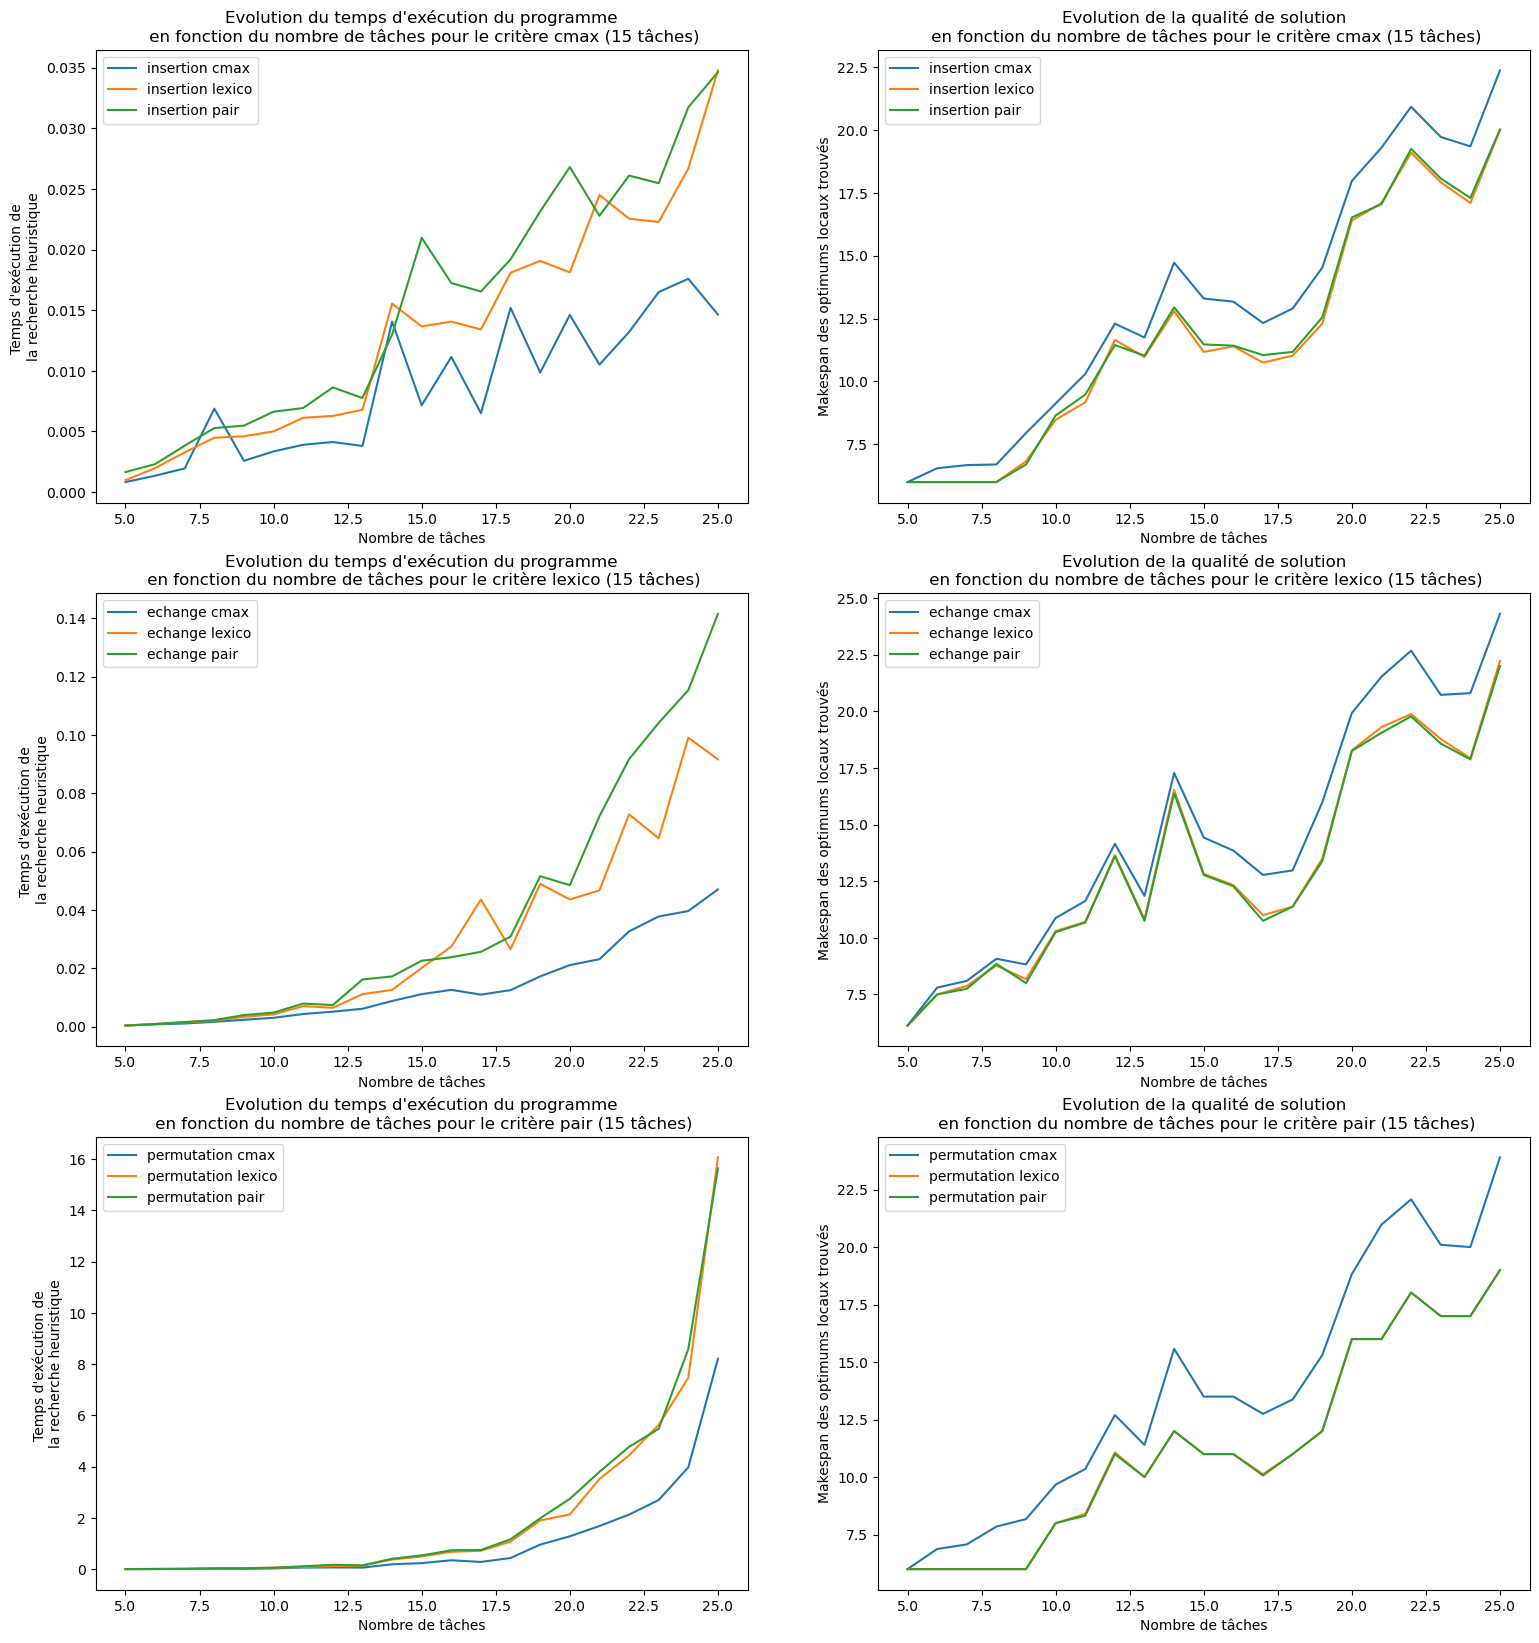

In [103]:
nb_taches = np.arange(5,26)
duree_max = 7
nb_machines = 5
nb_moyen = 40
list_voisinage = [insertion, echange, permutation]
graph_nbTache_VoisinbyCritere(nb_taches, duree_max, nb_machines, nb_moyen, list_voisinage)

In [104]:
def graph_nbTache_CriterebyVoisin(nb_taches, duree_max, nb_machines, nb_moyen, list_voisinage):
    """ Args :
        n (list{int}) : liste de différents nombres de tâches
        duree_max (int) : durée maximale d'une tâche
        nb_machines (int) : nombre de machines dont on dispose
        nb_moyen (int) : nombre de répétitions pour chaque combinaisons
        list_voisinage (list{function}) : list de fonction de voisinage
        return (void) : Affiche des graphiques du temps d'exécution / qualité de solution en fonction du nombre de tâches
    """
    temps = np.zeros((9, nb_taches.shape[0]))
    qualite = np.zeros((9, nb_taches.shape[0]))

    fig = plt.figure()
    fig.set_size_inches(18.5, 20)
    fig.set_dpi(100)
    
    ax1 = fig.add_subplot(3,2,1) # tps d'exécution / variation nb machines pour insertion
    ax2 = fig.add_subplot(3,2,2) # qualité / variation nb machines pour insertion échange
    ax3 = fig.add_subplot(3,2,3) # tps d'exécution / variation nb machines pour échange
    ax4 = fig.add_subplot(3,2,4) # qualité / variation nb machines pour échange
    ax5 = fig.add_subplot(3,2,5) # tps d'exécution / variation nb machines pour permutation
    ax6 = fig.add_subplot(3,2,6) # qualité / variation nb machines pour permutation

    dico_combinaison = {0:"insertion cmax", 3:" insertion lexico", 6:"insertion pair", 
                        1:"echange cmax", 4:"echange lexico", 7:"echange pair",
                        2:"permutation cmax", 5:"permutation lexico", 8:"permutation pair"}
    
    for j in range(nb_taches.shape[0]) :
        dict_taches = genererTaches(nb_taches[j], duree_max)
        ordon_init = ordon_alea(dict_taches, nb_machines)

        for i in range(nb_moyen) :
            if i%5 == 0 :
                ordon_init = ordon_alea(dict_taches, nb_machines)

            cpt = 0
            
            for critere in [cmax, lexico, pair]:
                for voisinage in list_voisinage:
                    clear_output(wait=True)
                    print("Loading ... \n Tâches %d / %d \n\t Répétitions : %d / %d \n\t\t Critere / voisinage %d / %d \n " %(j+5, nb_taches[-1], i, nb_moyen, cpt+1, 9))
                    t1 = time.time()
                    optimum_local = recherche_heuristique(ordon_init, dict_taches, nb_machines, voisinage, critere)
                    t2 = time.time()
                    t = t2-t1
                    temps[cpt][j] += t
                    qualite[cpt][j] += makespan(optimum_local)
                    cpt += 1


    for i in range(9):
        label = dico_combinaison[i]
        if(i<3):         
            ax1.plot(nb_taches, temps[i]/nb_moyen, label=label)
            ax2.plot(nb_taches, qualite[i]/nb_moyen, label=label)
        elif(i<6):
            ax3.plot(nb_taches, temps[i]/nb_moyen, label=label)
            ax4.plot(nb_taches, qualite[i]/nb_moyen, label=label)
        else:
            ax5.plot(nb_taches, temps[i]/nb_moyen, label=label)
            ax6.plot(nb_taches, qualite[i]/nb_moyen, label=label)

    ax1.set_xlabel("Nombre de tâches")
    ax1.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax1.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de tâches pour le critère cmax (15 tâches)")

    ax2.set_xlabel("Nombre de tâches")
    ax2.set_ylabel("Makespan des optimums locaux trouvés")
    ax2.set_title("Evolution de la qualité de solution\n en fonction du nombre de tâches pour le critère cmax (15 tâches)")

    ax3.set_xlabel("Nombre de tâches")
    ax3.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax3.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de tâches pour le critère lexico (15 tâches)")

    ax4.set_xlabel("Nombre de tâches")
    ax4.set_ylabel("Makespan des optimums locaux trouvés")
    ax4.set_title("Evolution de la qualité de solution\n en fonction du nombre de tâches pour le critère lexico (15 tâches)")

    ax5.set_xlabel("Nombre de tâches")
    ax5.set_ylabel("Temps d'exécution de \nla recherche heuristique")
    ax5.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de tâches pour le critère pair (15 tâches)")

    ax6.set_xlabel("Nombre de tâches")
    ax6.set_ylabel("Makespan des optimums locaux trouvés")
    ax6.set_title("Evolution de la qualité de solution\n en fonction du nombre de tâches pour le critère pair (15 tâches)")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    ax6.legend()

Loading ... 
 Tâches 25 / 25 
	 Répétitions : 39 / 40 
		 Critere / voisinage 9 / 9 
 


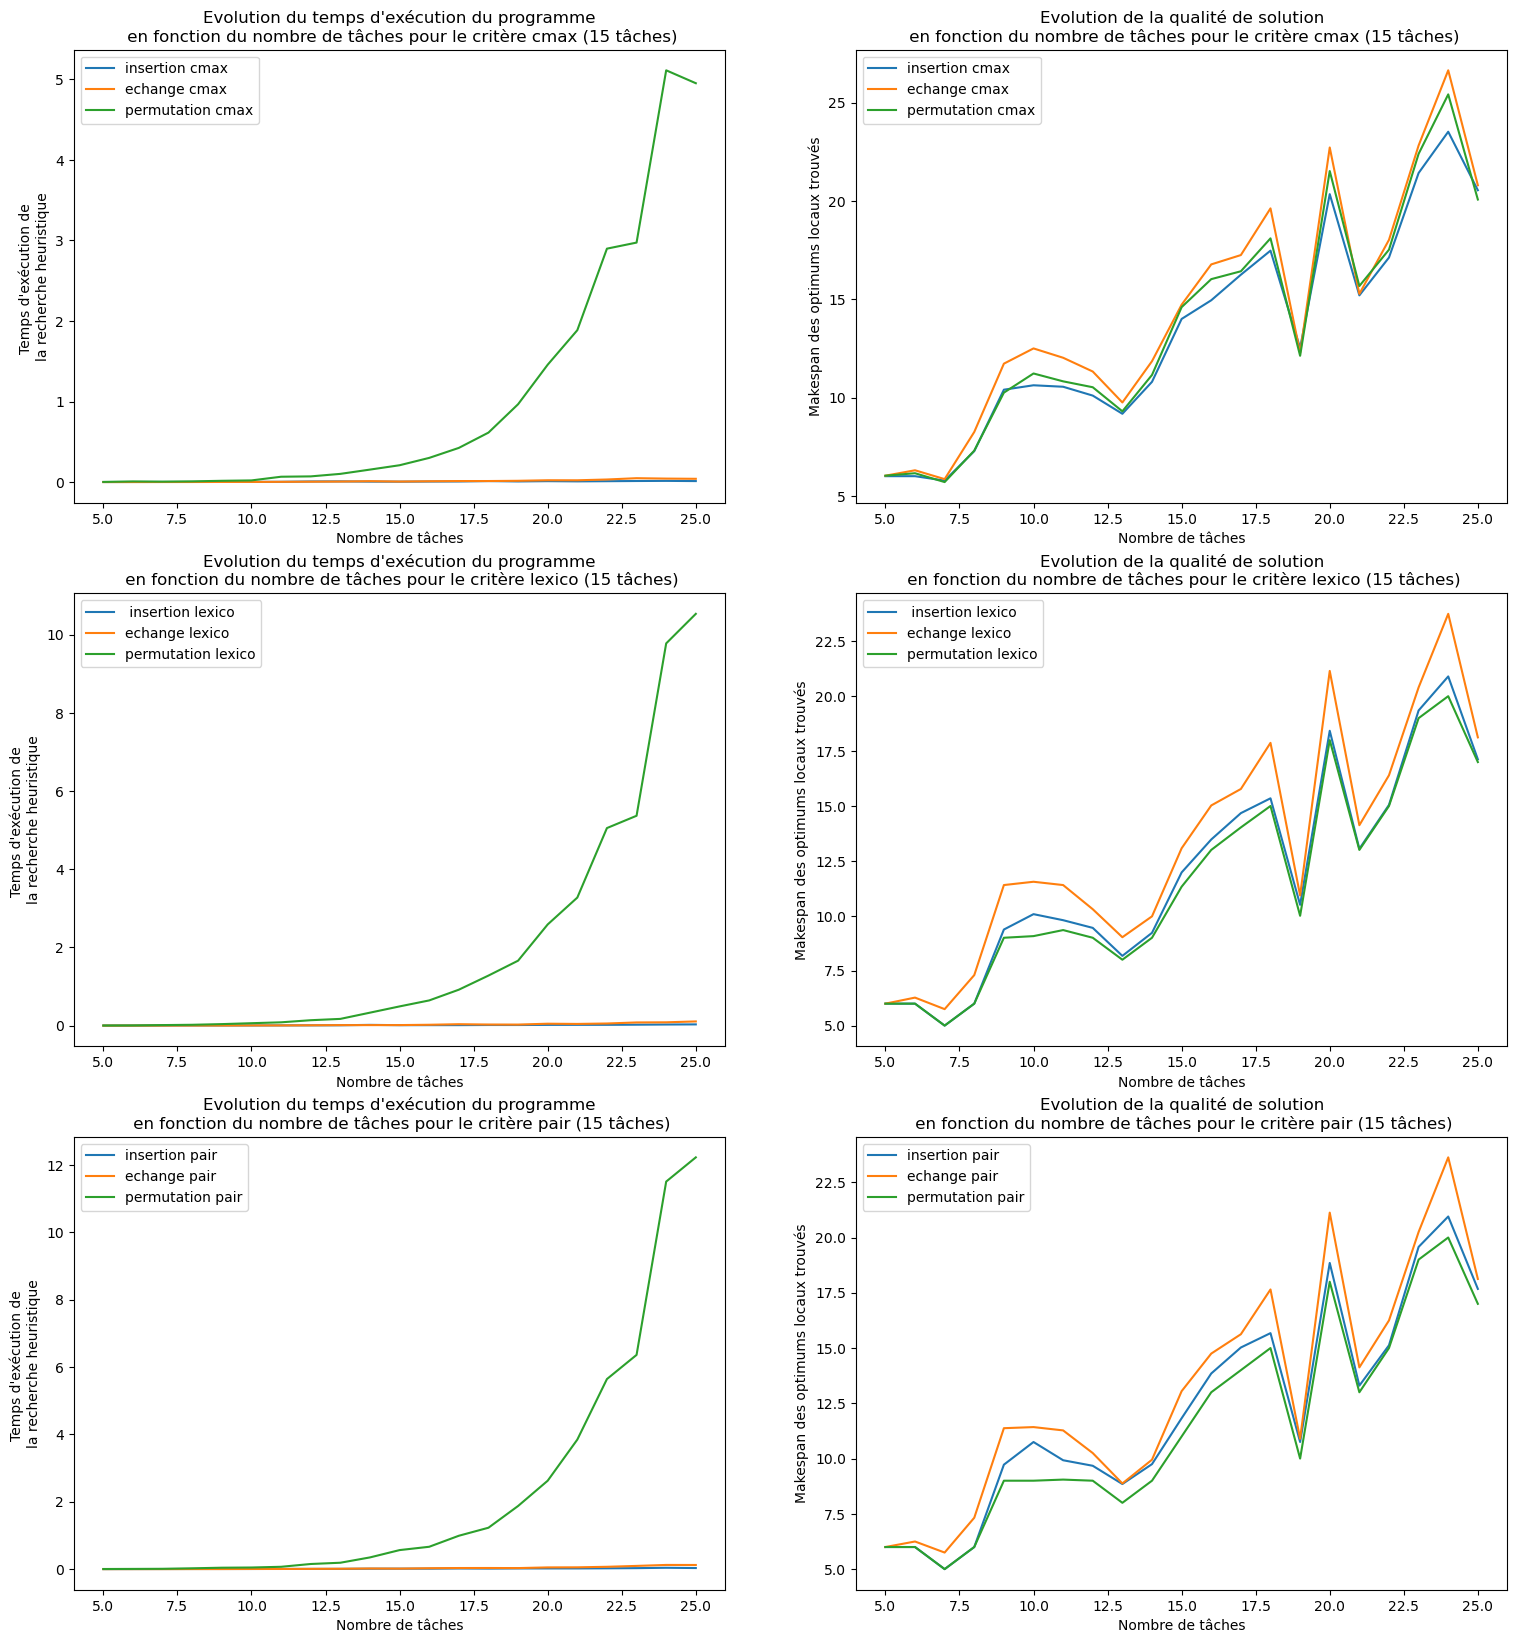

In [105]:
nb_taches = np.arange(5,26)
duree_max = 7
nb_machines = 5
nb_moyen = 40
list_voisinage = [insertion, echange, permutation]
graph_nbTache_CriterebyVoisin(nb_taches, duree_max, nb_machines, nb_moyen, list_voisinage)

In [106]:
def graph_nbMachines_algoListes(nb_taches, duree_max, nb_machines, nb_moyen):
    """ Args :
        n (int) : nombres de tâches
        duree_max (int) : durée maximale d'une tâche
        nb_machines (int) : nombre de machines dont on dispose
        nb_moyen (int) : nombre de répétitions pour chaque combinaisons
        return (void) : Affiche des graphiques du temps d'exécution / qualité de solution en fonction du nombre de tâches
    """
    temps = np.zeros((2, nb_machines.shape[0]))
    qualite = np.zeros((2, nb_machines.shape[0]))

    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    fig.set_dpi(100)
    
    ax1 = fig.add_subplot(1,2,1) # tps d'exécution / variation nb machines pour insertion / échange
    ax2 = fig.add_subplot(1,2,2) # qualité / variation nb machines pour insertion / échange

    for j in range(nb_machines.shape[0]) :
        dict_taches = genererTaches(nb_taches, duree_max)

        for i in range(nb_moyen) :
            t1 = time.time()
            optimum_local_liste = algoListe(dict_taches, nb_machines[j], isLPT=False)
            t2 = time.time()
            t = t2-t1
            temps[0][j] += t
            qualite[0][j] += makespan(optimum_local_liste)

            t1 = time.time()
            optimum_local_LPT = algoListeLPT(dict_taches, nb_machines[j])
            t2 = time.time()
            t = t2-t1
            temps[1][j] += t
            qualite[1][j] += makespan(optimum_local_LPT)

    ax1.plot(nb_machines, temps[0]/nb_moyen, label="Algorithme de liste")
    ax1.plot(nb_machines, temps[1]/nb_moyen, label="Algorithme LPT")
    ax2.plot(nb_machines, qualite[0]/nb_moyen, label="Algorithme de liste")
    ax2.plot(nb_machines, qualite[1]/nb_moyen, label="Algorithme LPT")


    ax1.set_xlabel("Nombre de machines")
    ax1.set_ylabel("Temps d'exécution de \nl'algorithme de liste")
    ax1.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de machines pour les algorithmes de listes (50 tâches)")

    ax2.set_xlabel("Nombre de machines")
    ax2.set_ylabel("Makespan des optimums locaux trouvés")
    ax2.set_title("Evolution de la qualité de solution\n en fonction du nombre de machines pour les algorithmes de listes (50 tâches)")
    
    ax1.legend()
    ax2.legend()

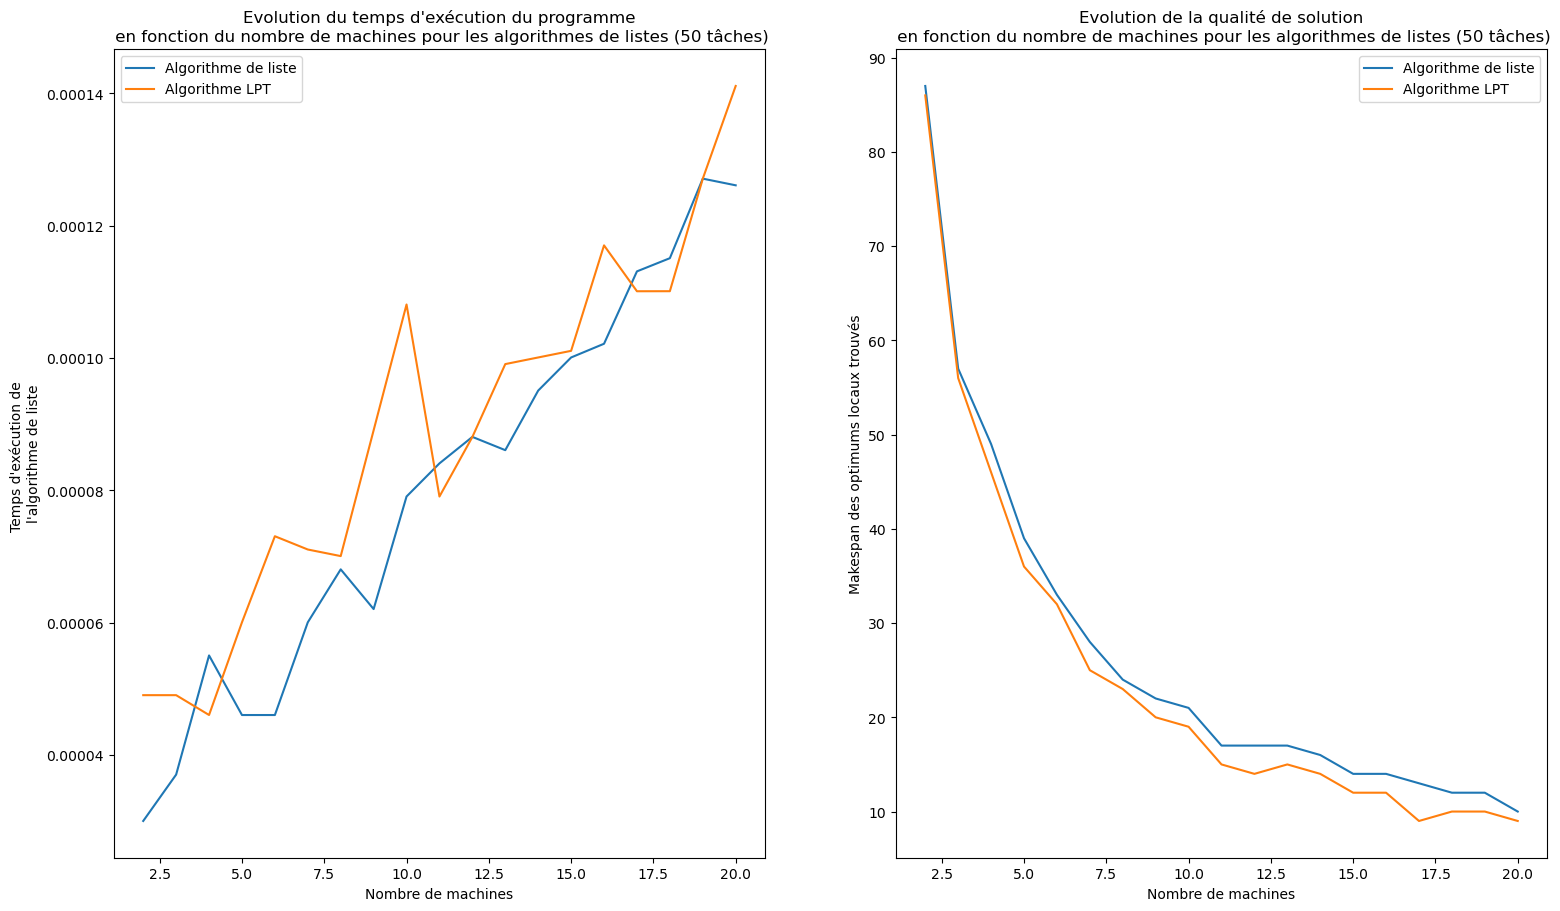

In [107]:
nb_taches = 50
duree_max = 7
nb_machines = np.arange(2,21)
nb_moyen = 1000
graph_nbMachines_algoListes(nb_taches, duree_max, nb_machines, nb_moyen)

In [108]:
def graph_nbTaches_algoListes(nb_taches, duree_max, nb_machines, nb_moyen):
    """ Args :
        n (int) : nombres de tâches
        duree_max (int) : durée maximale d'une tâche
        nb_machines (int) : nombre de machines dont on dispose
        nb_moyen (int) : nombre de répétitions pour chaque combinaisons
        return (void) : Affiche des graphiques du temps d'exécution / qualité de solution en fonction du nombre de tâches
    """
    temps = np.zeros((2, nb_taches.shape[0]))
    qualite = np.zeros((2, nb_taches.shape[0]))

    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    fig.set_dpi(100)
    
    ax1 = fig.add_subplot(1,2,1) # tps d'exécution / variation nb machines pour insertion / échange
    ax2 = fig.add_subplot(1,2,2) # qualité / variation nb machines pour insertion / échange

    for j in range(nb_taches.shape[0]) :
        dict_taches = genererTaches(nb_taches[j], duree_max)
        for i in range(nb_moyen) :
            t1 = time.time()
            optimum_local_liste = algoListe(dict_taches, nb_machines, isLPT=False)
            t2 = time.time()
            t = t2-t1
            temps[0][j] += t
            qualite[0][j] += makespan(optimum_local_liste)

            t1 = time.time()
            optimum_local_LPT = algoListeLPT(dict_taches, nb_machines)
            t2 = time.time()
            t = t2-t1
            temps[1][j] += t
            qualite[1][j] += makespan(optimum_local_LPT)

    ax1.plot(nb_taches, temps[0]/nb_moyen, label="Algorithme de liste")
    ax1.plot(nb_taches, temps[1]/nb_moyen, label="Algorithme LPT")
    ax2.plot(nb_taches, qualite[0]/nb_moyen, label="Algorithme de liste")
    ax2.plot(nb_taches, qualite[1]/nb_moyen, label="Algorithme LPT")


    ax1.set_xlabel("Nombre de tâches")
    ax1.set_ylabel("Temps d'exécution de \nl'algorithme de liste")
    ax1.set_title("Evolution du temps d'exécution du programme\n en fonction du nombre de machines pour les algorithmes de listes")

    ax2.set_xlabel("Nombre de tâches")
    ax2.set_ylabel("Makespan des optimums locaux trouvés")
    ax2.set_title("Evolution de la qualité de solution\n en fonction du nombre de machines pour les algorithmes de listes")
    
    ax1.legend()
    ax2.legend()

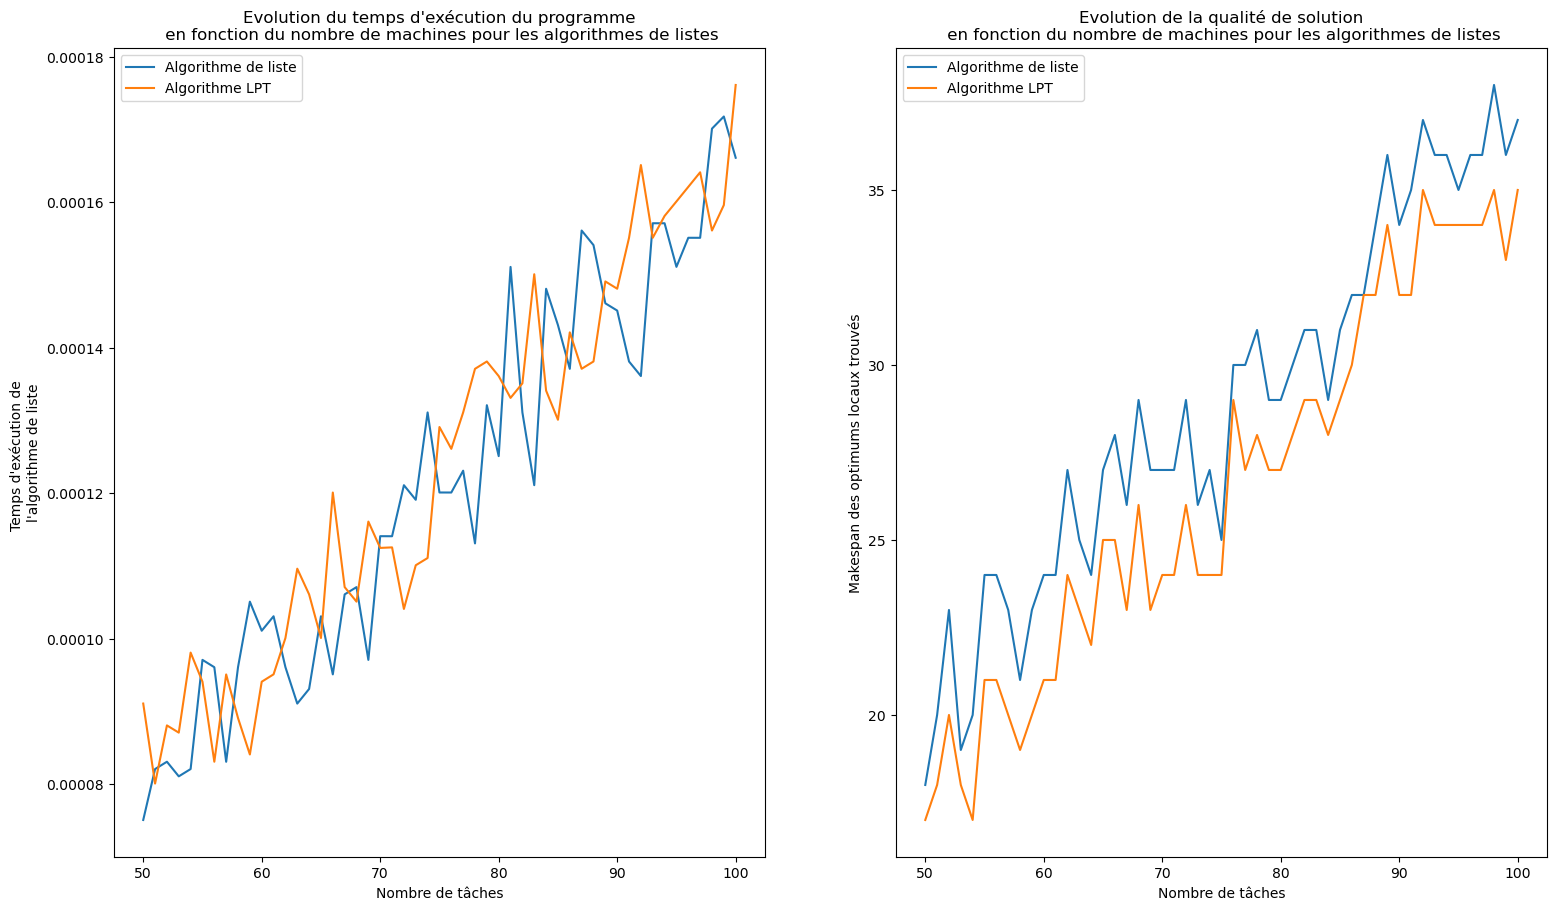

In [109]:
nb_taches = np.arange(50,101)
duree_max = 7
nb_machines = 10
nb_moyen = 1000
graph_nbTaches_algoListes(nb_taches, duree_max, nb_machines, nb_moyen)